<a href="https://colab.research.google.com/github/Chuckboliver/Drinking-Waste-Classification/blob/main/DrinkingWasteClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drinking Waste Classification**

## ***Import***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
import matplotlib.pyplot as plt
from keras.preprocessing import image
import keras.backend as K
import random

Mounted at /content/drive


## ***Load data***

In [ ]:
data_path = '/content/drive/MyDrive/dl_dataset/dataset_70_15_15.npz'
data = np.load(data_path)
print(*[d for d in data])
x_train = data["x_train"]
y_train = data["y_train"]
x_validation = data["x_validation"]
y_validation = data["y_validation"]
x_test = data["x_test"]
y_test = data["y_test"]
train_size = len(x_train)
validation_size = len(x_validation)
test_size = len(x_test)
print(f"Train size : {train_size}")
print(f"Validation size : {validation_size}")
print(f"Test size : {test_size}")

x_train y_train x_validation y_validation x_test y_test
Train size : 7490
Validation size : 1605
Test size : 1604


## ***Convolutional base***

In [ ]:
# Instantiate convolutional base
img_width, img_height = 224, 224
batch_size = 256
n_class = 3
conv_base = InceptionV3(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3),
                  pooling="avg"
                  )  # 3 = number of channels in RGB pictures
conv_base.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


## ***Data preprocessing***

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_class)
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size,
    shuffle=True
)

y_validation = tf.keras.utils.to_categorical(y_validation, num_classes=n_class)
validation_generator = val_datagen.flow(
    x_validation,
    y_validation,
    batch_size=batch_size,
    shuffle=True
)

## ***Classifier***

In [ ]:
epochs = 100

model = models.Sequential()
model.add(conv_base)

model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu', input_dim=5 * 5 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_class, activation='softmax'))
# Compile model
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=validation_generator,
                    verbose=True)

Epoch 1/100
30/30 [==============================] - 34s 451ms/step - loss: 0.9640 - acc: 0.6956 - val_loss: 0.3450 - val_acc: 0.8866
Epoch 2/100
30/30 [==============================] - 10s 327ms/step - loss: 0.4082 - acc: 0.8356 - val_loss: 0.2669 - val_acc: 0.9090
Epoch 3/100
30/30 [==============================] - 10s 323ms/step - loss: 0.3230 - acc: 0.8732 - val_loss: 0.2439 - val_acc: 0.9134
Epoch 4/100
30/30 [==============================] - 10s 331ms/step - loss: 0.3235 - acc: 0.8697 - val_loss: 0.2122 - val_acc: 0.9277
Epoch 5/100
30/30 [==============================] - 10s 324ms/step - loss: 0.2852 - acc: 0.8865 - val_loss: 0.1886 - val_acc: 0.9396
Epoch 6/100
30/30 [==============================] - 10s 323ms/step - loss: 0.2552 - acc: 0.9028 - val_loss: 0.1797 - val_acc: 0.9389
Epoch 7/100
30/30 [==============================] - 10s 323ms/step - loss: 0.2403 - acc: 0.9031 - val_loss: 0.1695 - val_acc: 0.9414
Epoch 8/100
30/30 [==============================] - 10s 324ms

## **Model summary**

In [ ]:
print(f"Model learning rate : {K.eval(model.optimizer.lr):.3f}")

Model learning rate : 0.001


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 23,904,035
Trainable params: 2,101,251
Non-trainable params: 21,802,784
_________________________________________________________________


## **Model save**


In [ ]:
model.save(f"model_70_15_15_b256_v9.h5")

## ***Accuracy & Loss***

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


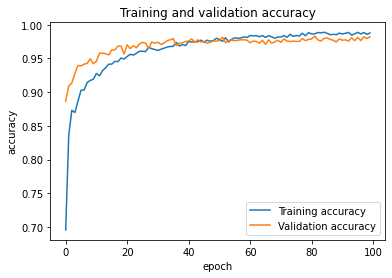

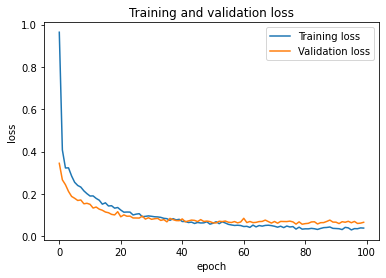

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')
plt.show()

## ***Test data***

In [ ]:
def predict(classifier, x_data, y_data):
  # Normalize to [0,1] for plt.imshow application
  x_data = np.true_divide(x_data, 255) 
  # Extract features
  #features = conv_base.predict(x_data.reshape(1,img_width, img_height, 3))
  # Make prediction
  prediction = classifier.predict(x_data.reshape(1,224,224,3))
  label = ["AluCan", "Glass", "PET"]
  result = label[np.argmax(prediction)]
  real = label[y_data]
  # Show picture
  plt.imshow(x_data)
  plt.show()
  # Write prediction
  print(prediction)
  print(f"AluCan : {prediction[0][0] * 100}% Glass : {prediction[0][1] * 100}% PET : {prediction[0][2] * 100}%")
  print(f"Real : {real}")
  print(f"Predict : {result}")

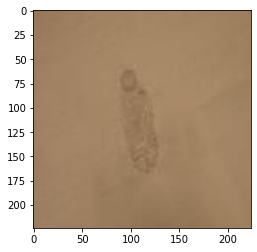

[[1.0303368e-07 1.2203192e-05 9.9998772e-01]]
AluCan : 1.030336775897922e-05% Glass : 0.0012203191545268055% PET : 99.99877214431763%
Real : PET
Predict : PET


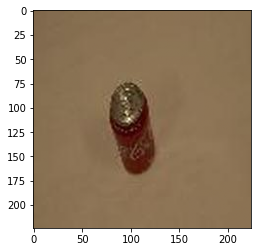

[[9.9986184e-01 1.3814075e-04 4.3091610e-09]]
AluCan : 99.98618364334106% Glass : 0.013814074918627739% PET : 4.3091610280043824e-07%
Real : AluCan
Predict : AluCan


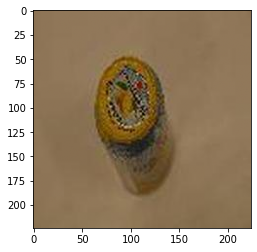

[[9.9998891e-01 1.1058500e-05 1.6221328e-08]]
AluCan : 99.99889135360718% Glass : 0.0011058499694627244% PET : 1.622132828060785e-06%
Real : AluCan
Predict : AluCan


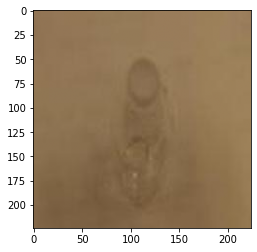

[[4.8001752e-05 3.2273540e-03 9.9672467e-01]]
AluCan : 0.0048001751565607265% Glass : 0.32273540273308754% PET : 99.67246651649475%
Real : PET
Predict : PET


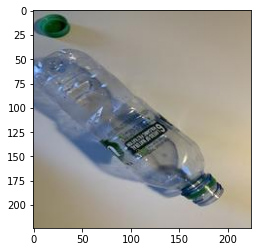

[[1.4640344e-08 4.9662805e-04 9.9950337e-01]]
AluCan : 1.4640344048189036e-06% Glass : 0.04966280539520085% PET : 99.95033740997314%
Real : PET
Predict : PET


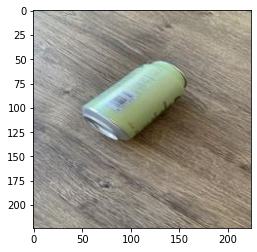

[[1.0000000e+00 2.8111585e-10 8.7169673e-12]]
AluCan : 100.0% Glass : 2.811158528182034e-08% PET : 8.716967252186958e-10%
Real : AluCan
Predict : AluCan


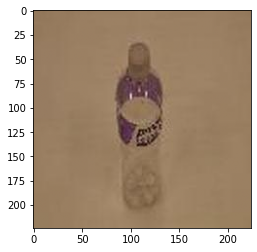

[[9.8787059e-09 1.5437033e-07 9.9999988e-01]]
AluCan : 9.878705853338943e-07% Glass : 1.5437032629961323e-05% PET : 99.99998807907104%
Real : PET
Predict : PET


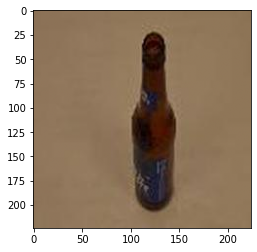

[[1.9861419e-10 1.0000000e+00 2.7363498e-10]]
AluCan : 1.9861419453537366e-08% Glass : 100.0% PET : 2.7363497578924978e-08%
Real : Glass
Predict : Glass


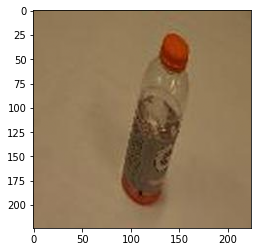

[[9.293343e-07 7.956113e-04 9.992035e-01]]
AluCan : 9.293343055105652e-05% Glass : 0.07956112967804074% PET : 99.92035031318665%
Real : PET
Predict : PET


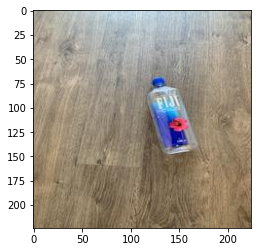

[[1.7808256e-04 1.8803108e-03 9.9794155e-01]]
AluCan : 0.017808255506679416% Glass : 0.1880310825072229% PET : 99.79415535926819%
Real : PET
Predict : PET


In [ ]:
# Define function to visualize predictions
def visualize_predictions(classifier, n_cases):
  for i in range(n_cases):
    test_set = [*zip(x_test, y_test)]
    x_to_test, y_to_test = random.choice(test_set)
    predict(classifier, x_to_test, y_to_test)

# Visualize predictions
visualize_predictions(model, 10)

In [ ]:
predict_x = model.predict(np.true_divide(x_test, 255)) 
predictions = np.argmax(predict_x, axis=1)
errors = np.where(predictions != y_test)[0]
print(f"index of error : \n{errors}")
print("\nNo of errors = {}/{}".format(len(errors),test_size))

index of error : 
[ 331  384  436  446  483  512  517  520  524  551  552  553  565  655
  679  685  688  789  808  812  818  824  829  838  847  853  856  871
  931  942  964 1015 1130 1149 1157 1320]

No of errors = 36/1604


In [ ]:
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=n_class)
score = model.evaluate(np.true_divide(x_test, 255), y_test_categorical)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

51/51 [==============================] - 4s 50ms/step - loss: 0.0617 - acc: 0.9776
acc: 97.76%


### ***Error images***

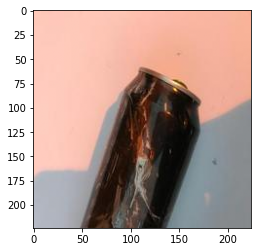

[[5.3915657e-02 9.4606405e-01 2.0338712e-05]]
AluCan : 5.391565710306168% Glass : 94.60640549659729% PET : 0.0020338711692602374%
Real : AluCan
Predict : Glass


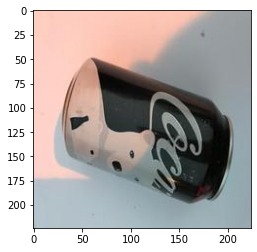

[[0.31199032 0.61411935 0.07389034]]
AluCan : 31.199032068252563% Glass : 61.41193509101868% PET : 7.389034330844879%
Real : AluCan
Predict : Glass


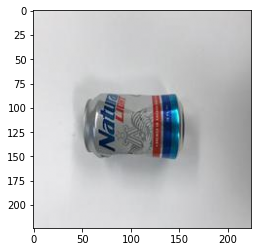

[[0.00689653 0.96580875 0.02729483]]
AluCan : 0.6896529346704483% Glass : 96.58087491989136% PET : 2.7294831350445747%
Real : AluCan
Predict : Glass


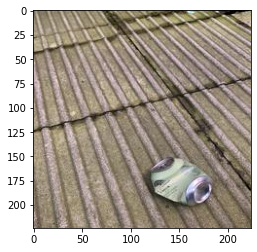

[[0.46522415 0.00294147 0.5318343 ]]
AluCan : 46.522414684295654% Glass : 0.29414729215204716% PET : 53.183430433273315%
Real : AluCan
Predict : PET


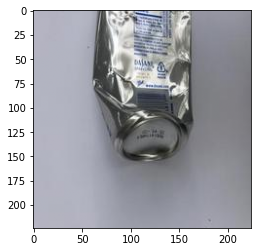

[[0.4059272  0.566122   0.02795082]]
AluCan : 40.59272110462189% Glass : 56.612199544906616% PET : 2.7950819581747055%
Real : AluCan
Predict : Glass


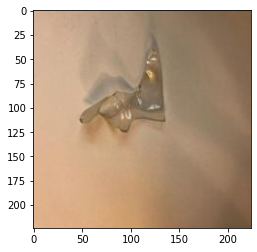

[[0.00268883 0.40372434 0.59358686]]
AluCan : 0.26888272259384394% Glass : 40.372434258461% PET : 59.358686208724976%
Real : Glass
Predict : PET


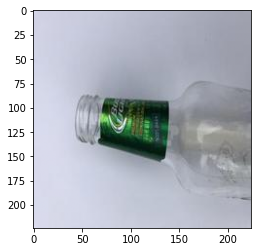

[[2.9495909e-06 3.4523174e-01 6.5476531e-01]]
AluCan : 0.00029495909075194504% Glass : 34.52317416667938% PET : 65.47653079032898%
Real : Glass
Predict : PET


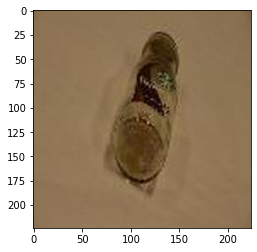

[[0.00470762 0.46998373 0.52530867]]
AluCan : 0.4707619547843933% Glass : 46.99837267398834% PET : 52.530866861343384%
Real : Glass
Predict : PET


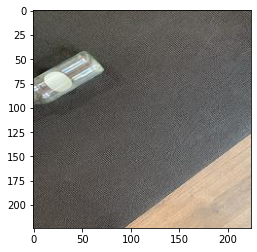

[[9.213904e-06 9.423255e-03 9.905675e-01]]
AluCan : 0.0009213904377247673% Glass : 0.9423254989087582% PET : 99.05675053596497%
Real : Glass
Predict : PET


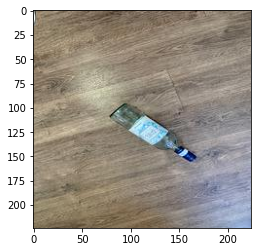

[[2.9030602e-08 2.8906935e-01 7.1093059e-01]]
AluCan : 2.9030601922386268e-06% Glass : 28.906935453414917% PET : 71.0930585861206%
Real : Glass
Predict : PET


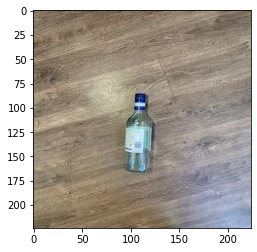

[[6.8828220e-12 1.8533386e-04 9.9981469e-01]]
AluCan : 6.882822003312361e-10% Glass : 0.018533386173658073% PET : 99.98146891593933%
Real : Glass
Predict : PET


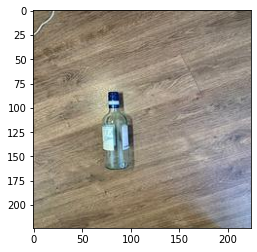

[[5.506230e-07 8.996244e-02 9.100370e-01]]
AluCan : 5.506229854290723e-05% Glass : 8.9962437748909% PET : 91.00369811058044%
Real : Glass
Predict : PET


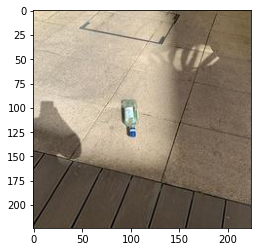

[[2.3260618e-06 3.7825182e-01 6.2174582e-01]]
AluCan : 0.00023260618036147207% Glass : 37.82518208026886% PET : 62.17458248138428%
Real : Glass
Predict : PET


In [ ]:
start_index = 0
end_index = 600
reverse = False
errors_list = errors[::-1] if reverse else errors
for index in errors_list:
  if start_index <= index <= end_index:
    x, y = x_test[index], y_test[index]
    predict(model, x, y)